In [1]:
import numpy as np

import itertools
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
import math

### TASK 1
 Using a programming language of your choice, implement the wiretap channel, so that it accepts an input $x\in\mathcal{X}$ and produces the corresponding pair of outputs $(y,z)$

In [2]:
MAX_ERRORS_CHANNEL = 1
MAX_ERRORS_EAVESDROPPER = 3
NUM_BITS = 7

In [3]:
a = [1, 0, 0, 1, 0, 0, 0]

`generateAllErrors()` generates all possible combinations of errors within a binary array of length num_bits

In [4]:
def generateAllErrors(num_bits, max_errors):
    if max_errors > num_bits or max_errors < 1:
        raise ValueError("max_errors must be between 1 and num_bits inclusive.")

    error_patterns =[]
    for error_count in range(0, max_errors + 1):
        for positions in itertools.combinations(range(num_bits), error_count):
            error = [0] * num_bits
            for pos in positions:
                error[pos] = 1
            error_patterns.append(error)

    return np.array(error_patterns)

In [5]:
def getRandomElement(vector):
    return vector[np.random.randint(len(vector))]

`xor_between_vectors()` do the xor operation between two vectors with the same length. If the vectors don't have the same length, an error is return.

In [6]:
def xor_between_vectors(a, b):
    if len(a) != len(b):
        raise ValueError("Array length should be equal")
    result = [x ^ y for x, y in zip(a, b)]
    return result

In [7]:
def are_the_same_array_index(a, all_errors):
    for i in range(len(all_errors)):
        if len(a) != len(all_errors[i]):
            raise ValueError("Array length should be equal")
        for k in range(len(a)):
            if a[k].any() == all_errors[i][k].any():
                return i
    return -1

`validateIndependency()` check the conditional independence and uniformity of our outputs. We call this method and then we can plot the result with `plot_statistic()`

In [8]:
def validateIndependency(x, n_iterations, num_bits, max_errors_channel, max_errors_eavesdropper):
    all_channel_errors = generateAllErrors(num_bits, max_errors_channel)
    all_eavesdropper_errors = generateAllErrors(num_bits, max_errors_eavesdropper)
    all_channel_errors_with_xor = [xor_between_vectors(x, i) for i in all_channel_errors]
    all_eavesdropper_errors_with_xor = [xor_between_vectors(x, i) for i in all_eavesdropper_errors]

    errors_channel = {"".join(str(bit) for bit in i): 0 for i in all_channel_errors_with_xor}  # Initialize for all possible edit distances
    errors_eavesdropper = {"".join(str(bit) for bit in i): 0 for i in all_eavesdropper_errors_with_xor}  # Initialize for all possible edit distances

    for i in range(n_iterations):
        b = getRandomElement(all_channel_errors_with_xor)
        c = getRandomElement(all_eavesdropper_errors_with_xor)
        key = "".join(str(bit) for bit in b)
        errors_channel[key] += 1
        key = "".join(str(bit) for bit in c)
        errors_eavesdropper[key] += 1

    return errors_channel, errors_eavesdropper

In [9]:
def plot_statistic(title, errors):
    sorted_errors = dict(sorted(errors.items(), key=lambda x: int(x[0], 2)))

    plt.figure(figsize=(15, 4))
    plt.bar(sorted_errors.keys(), sorted_errors.values(), color='#b3071b')

    plt.xlabel('Error Pattern', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title(title, fontsize=13, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

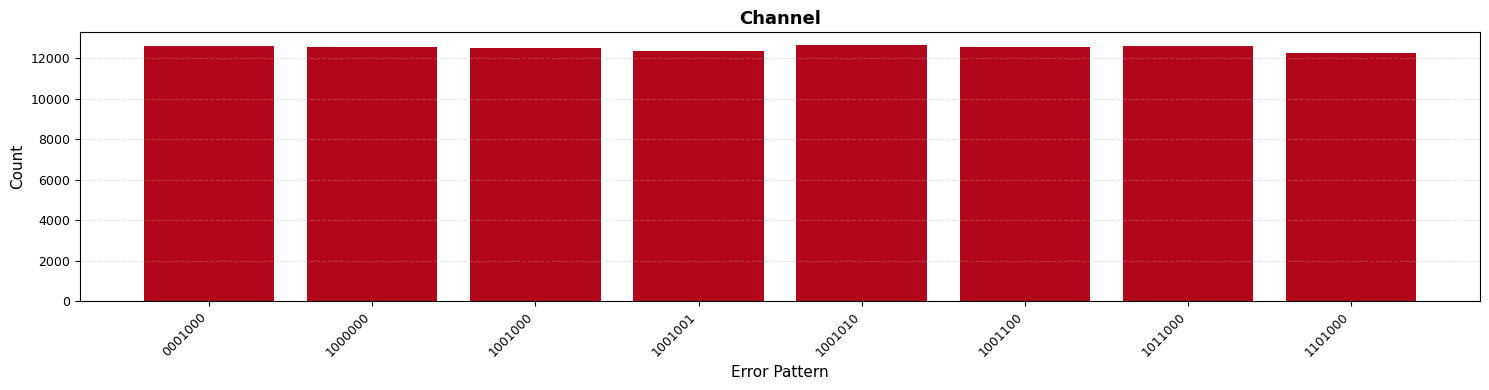

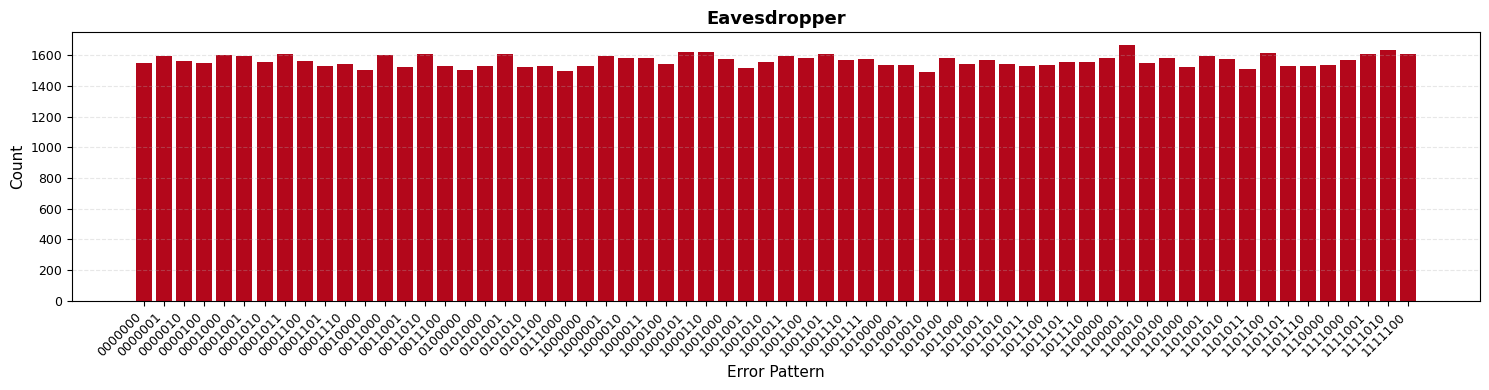

In [10]:
errors_channel, errors_eavesdropper = validateIndependency(a, 100000, NUM_BITS, MAX_ERRORS_CHANNEL, MAX_ERRORS_EAVESDROPPER)
plot_statistic("Channel", errors_channel)
plot_statistic("Eavesdropper", errors_eavesdropper)

### TASK 2
Using a programming language of your choice, implement the random binning encoder, so that itaccepts an input $u\in\mathcal{M}$ and produces the corresponding output $x\in\mathcal{X}'$

In [11]:
INPUT_LENGTH = 3

In [12]:
u = [0, 0, 0]
binary_strings = [
    "0000000", "1000110", "0100101", "0010011",
    "0001111", "1100011", "1010101", "1001001",
    "0110110", "0101010", "0011100", "1110000",
    "1101100", "1011010", "0111001", "1111111"
]

In [13]:
hamming = [[int(bit) for bit in code] for code in binary_strings]

In [14]:
def generate_codewords(u):
    u = np.insert(u, 0, 0)
    for i in hamming:
        if np.array_equal(i[:4], u):
            # the first elemnet is the prefix
            return np.array([i, xor_between_vectors(i, [1,1,1,1,1,1,1])])
    return None, None

In [15]:
def encoder(input):
    return getRandomElement(generate_codewords(input))

In [16]:
t = encoder(u)
print(t)

[0 0 0 0 0 0 0]


### TASK 3
 Using a programming language of your choice, implement the legitimate decoder, so that it accepts an input $y\in\mathcal{Y}$ and produces the corresponding output $\hat{u}∈\mathcal{M}$

In [17]:
input = [1, 0, 1, 0, 1, 1, 1]

In [18]:
def convert_array_to_string(arr):
    return "".join(str(x) for x in arr)

In [19]:
def minimum_distance_with_code(x, all_word_code):
    distances = {}
    for k in all_word_code:
        distance = 0
        if len(x) != len(k):
            raise ValueError("Array length should be equal")
        for i in range(len(x)):
            if x[i] != k[i]:
                distance += 1
        distances[convert_array_to_string(k)] = distance

    return min(distances, key=distances.get)

In [20]:
def find_real_input(codeword):
    codeword = np.array([int(bit) for bit in codeword])
    if(codeword[0] == 0):
        return np.array(codeword[1:4])
    return np.array(xor_between_vectors(codeword[1:4], [1, 1, 1]))

In [21]:
def decoder(codeword):
    word = minimum_distance_with_code(codeword, hamming)
    word = find_real_input(word)
    return word

In [22]:
word = decoder(input)
print(word)

[1 0 1]


### TASK 4


 * Using a programming language of your choice, implement the encoder +
eavesdropper channel chain, so that it accepts an input $u\in\mathcal{M}$ and produces the corresponding output $z\in\mathcal{Z}$.

* For each possible value of $u$, simulate at least $100·|\mathcal{Z}|≃104$ realizations of the chain and gather the empirical distribution of $z$

* Plot or tabulate the empirical conditional pmd of $z$ given $u$, $\hat{p}_{z|u}(c|d)$ for all values of $d$

* Compute the empirical joint $\hat{p}_{u,z}(d,c)$ and marginal distributions $\hat{p}_u(d),\hat{p}_z(c)$ and the mutual information
$$
\hat{I}(u,z)= \sum_{d\in\mathcal{M},c\in\mathcal{Z}} \hat{p}_{u,z}(d,c)\log_2\frac{\hat{p}_{u,z}(d, c)}{\hat{p}_u(d) \hat{p}_z(c)}
$$

In [23]:
all_possible_input = [list(tupla) for tupla in itertools.product([0, 1], repeat=3)]

In [24]:
def encoder_plus_channel_errors(u, max_error):
    codeword = getRandomElement(generate_codewords(u))
    if codeword is None:
        raise ValueError("No valid codeword found for the given input.")
    # Generate all possible error patterns
    error = getRandomElement(generateAllErrors(NUM_BITS, max_error))
    # Apply errors to the codewords
    codeword_with_errors = xor_between_vectors(codeword, error)
    return np.array(codeword_with_errors)

In [25]:
def calculate_empirical_distribution(all_possible_input, iterations):
    input_output_numbers_map = Counter()

    for u in all_possible_input:
        for _ in range(iterations):
            t = encoder_plus_channel_errors(u, MAX_ERRORS_EAVESDROPPER)

            input_output_numbers_map[(convert_array_to_string(u), convert_array_to_string(t))] += 1

    return input_output_numbers_map

In [26]:
def compute_distributions(joint_counts, total_samples):
    # Joint p(u,z)
    p_uz = {k: v / total_samples for k, v in joint_counts.items()}

    # Marginals
    p_u = defaultdict(float)
    p_z = defaultdict(float)
    for (u, z), p in p_uz.items():
        p_u[u] += p
        p_z[z] += p

    return p_uz, p_u, p_z

In [27]:
def compute_mutual_information_and_entropy(p_uz, p_u, p_z):
    I = 0.0  # Mutual information
    H_u = 0.0  # Entropy of U

    # Compute mutual information
    for (u, z), p_joint in p_uz.items():
        if p_joint > 0:
            I += p_joint * math.log2(p_joint / (p_u[u] * p_z[z]))

    # Compute entropy H(U)
    for u_val, p_val in p_u.items():
        if p_val > 0:
            H_u -= p_val * math.log2(p_val)

    return I, H_u

In [28]:
def plot_empirical_distribution(df):
    plt.figure(figsize=(22, 6))
    sns.heatmap(df, cmap="viridis", annot=False, )
    plt.xlabel("z (channel output)")
    plt.ylabel("u (original message)")
    plt.title("Empirical Conditional PMD: p̂(z | u)")
    plt.tight_layout()
    plt.show()

In [29]:
def convert_to_data_frame (data):
    df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in data.items()],
    columns=["row", "col", "value"])
    heatmap_data = df.pivot(index="row", columns="col", values="value")

    heatmap_data = heatmap_data.astype(float)
    return heatmap_data

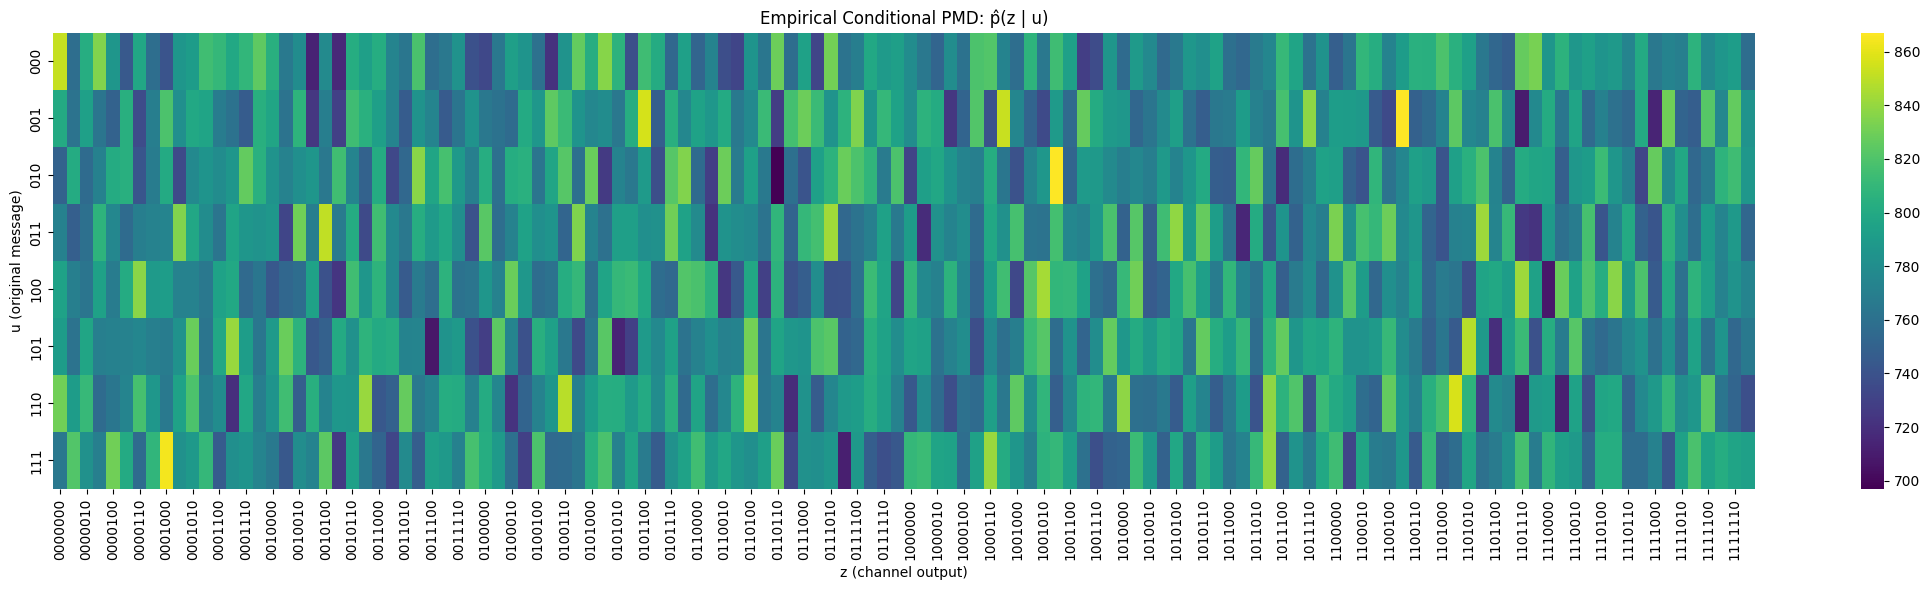

Mutual Information I(U;Z): 0.000855
Entropy H(U): 3.000000


In [30]:
iterations = 100000
input_output_numbers_map = calculate_empirical_distribution(all_possible_input, iterations)
df = convert_to_data_frame(input_output_numbers_map)
plot_empirical_distribution(df)
total_samples = len(all_possible_input) * iterations
p_uz, p_u, p_z = compute_distributions(input_output_numbers_map, total_samples)

I_u_z, H_u = compute_mutual_information_and_entropy(p_uz, p_u, p_z)
print(f"Mutual Information I(U;Z): {I_u_z:.6f}")
print(f"Entropy H(U): {H_u:.6f}")

### TASK 5


Using a programming language of your choice, implement the wiretap BSC, so that
* it can be simulated with arbitrary values of $\epsilon, \delta$
* it can be connected in between the random binning encoder developed in Task 2, and the decoder developed in Task 3

In [31]:
EPSILON = 0.1
DELTA = 0.3

In [32]:
def bsc(input, probability_error):
    flip = np.random.rand(len(input)) < probability_error
    output_bits = xor_between_vectors(input, flip.astype(int))
    return output_bits

In [33]:
def number_of_errors(input, output):
    if len(input) != len(output):
        raise ValueError("Array length should be equal")
    errors = 0
    for i in range(len(input)):
        if input[i] != output[i]:
            errors += 1
    return errors

In [34]:
LONG_INPUT_LENGTH = 50000
input = np.random.randint(0, 2, LONG_INPUT_LENGTH)
legitimate_channel = bsc(input, EPSILON)
legitimate_channel_errors = number_of_errors(input, legitimate_channel)
print(f"Legitimate channel errors: {legitimate_channel_errors}. BER = {legitimate_channel_errors/LONG_INPUT_LENGTH}")
eavesdropper_channel = bsc(input, DELTA)
eavesdropper_channel_errors = number_of_errors(input, eavesdropper_channel)
print(f"Eavesdropper channel errors: {eavesdropper_channel_errors}. BER = {eavesdropper_channel_errors/LONG_INPUT_LENGTH}")

errors = 0
for _ in range(500):
    input = np.random.randint(0, 2, INPUT_LENGTH)
    output = decoder(bsc(encoder(input), EPSILON))
    errors = errors + 1 if np.any(input != output) else errors
print(f"Number of errors in legitimate channel (with epsilon={EPSILON}): {errors}")

errors = 0
for _ in range(500):
    input = np.random.randint(0, 2, INPUT_LENGTH)
    output = decoder(bsc(encoder(input), DELTA))
    errors = errors + 1 if np.any(input != output) else errors
print(f"Number of errors in eavesdropper channel (with delta={DELTA}): {errors}")

Legitimate channel errors: 4930. BER = 0.0986
Eavesdropper channel errors: 14963. BER = 0.29926
Number of errors in legitimate channel (with epsilon=0.1): 83
Number of errors in eavesdropper channel (with delta=0.3): 358


### TASK 6

 Choose several values of $\epsilon$ and $\delta$, and for each $(\epsilon, \delta)$ pair
 1. repeat the simulations in Tasks 3-4 with the wiretap BSC
 2. evaluate the resulting reliability in terms of Bob’s error rate on the secret message $\mathbb{P}[\hat{u}\neq u]$
 3. evaluate the resulting secrecy in terms of leaked information to Eve on the secret message $I(u;z)$
 4. compute the total variation distance between $p_{u\hat{u}z}$ and $p_{u\hat{u}^*z^*}$ and the mechanism security in terms of distinguishability from the ideal counterpart
 5. compare the distinguishability computed in point 4 with an upper bound obtained combining the
 results in points 2-3

In [35]:
def calculate_empirical_distribution_with_bsc(all_possible_input, iterations, delta):
    input_output_numbers_map = Counter()

    for u in all_possible_input:
        for _ in range(iterations):
            t = bsc(encoder(u), delta)

            input_output_numbers_map[(convert_array_to_string(u), convert_array_to_string(t))] += 1

    return input_output_numbers_map

In [36]:
def compute_error_probability(u, u_hat):
    return np.mean(u != u_hat)

In [37]:
def total_variation_distance(p, q):
    all_keys = set(p.keys()).union(q.keys())
    tvd = 0.5 * sum(abs(p.get(k, 0) - q.get(k, 0)) for k in all_keys)
    return tvd


For epsilon=0.01 and delta=0.55
Bob's Error Probability with epsilon=0.01: 0.0


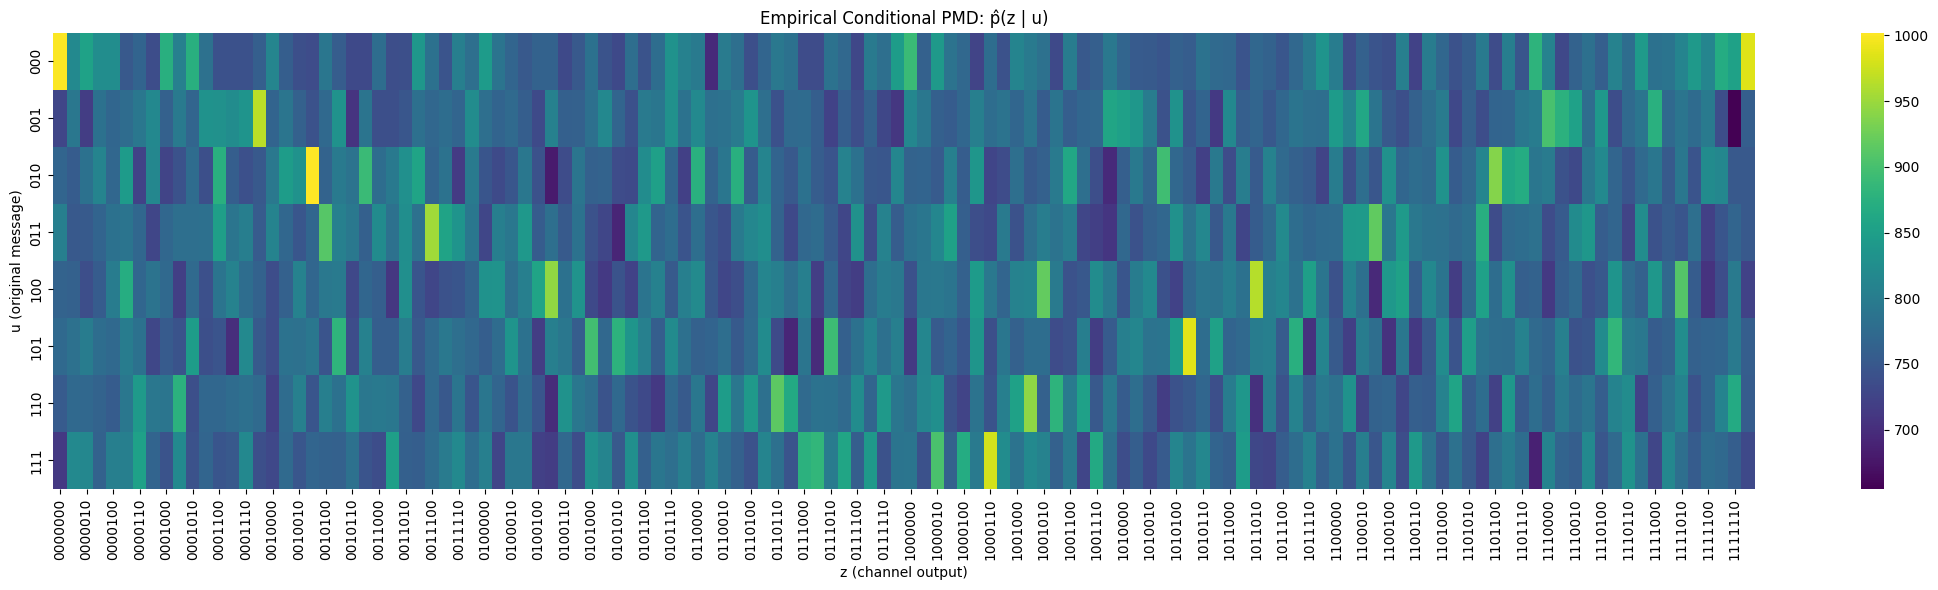

Mutual Information (with delta=0.55) I(U;Z): 0.002111
Entropy (with delta=0.55) H(U): 3.000000

For epsilon=0.05 and delta=0.5
Bob's Error Probability with epsilon=0.05: 0.04


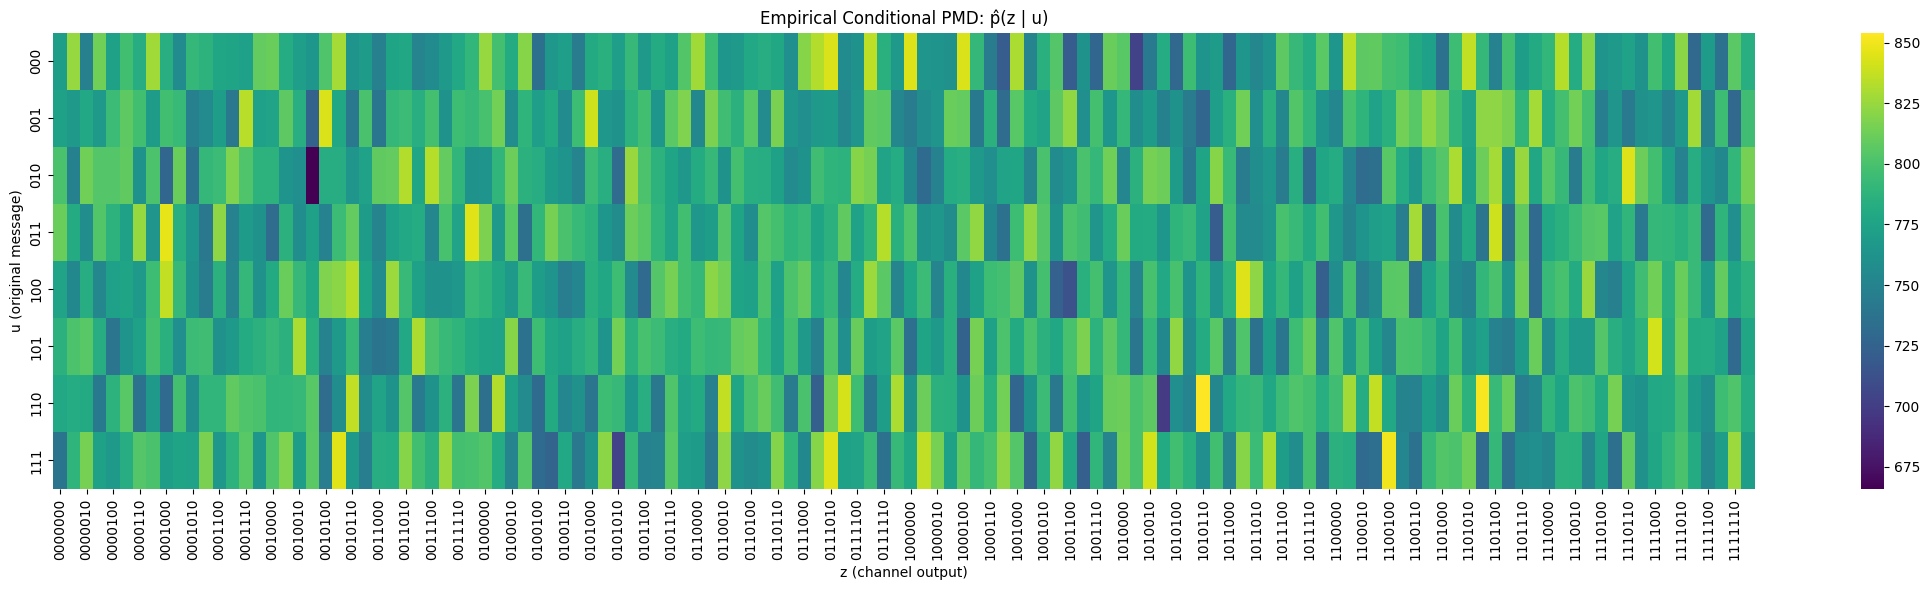

Mutual Information (with delta=0.5) I(U;Z): 0.000757
Entropy (with delta=0.5) H(U): 3.000000

For epsilon=0.1 and delta=0.45
Bob's Error Probability with epsilon=0.1: 0.04666666666666666


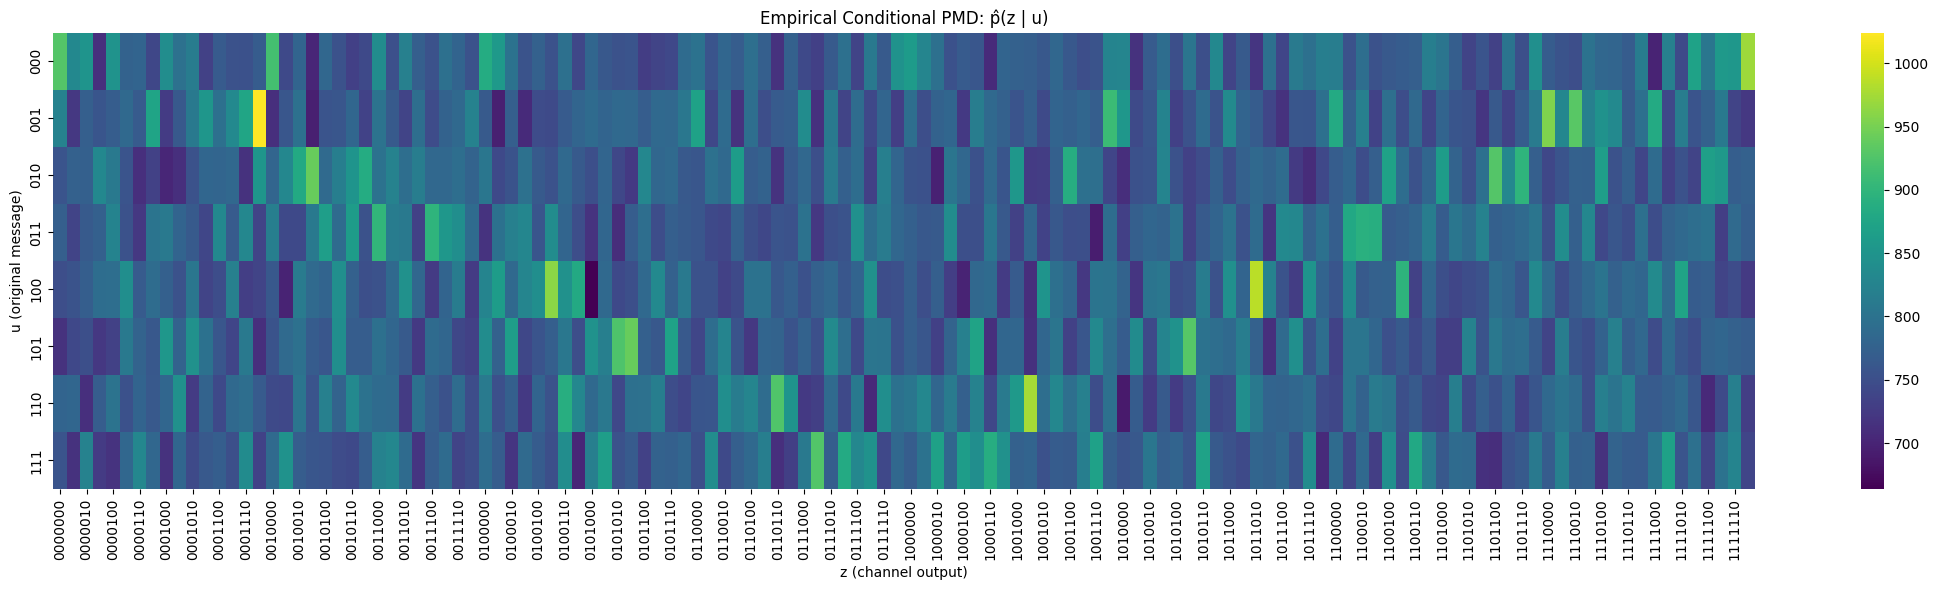

Mutual Information (with delta=0.45) I(U;Z): 0.002172
Entropy (with delta=0.45) H(U): 3.000000

For epsilon=0.15 and delta=0.4
Bob's Error Probability with epsilon=0.15: 0.12


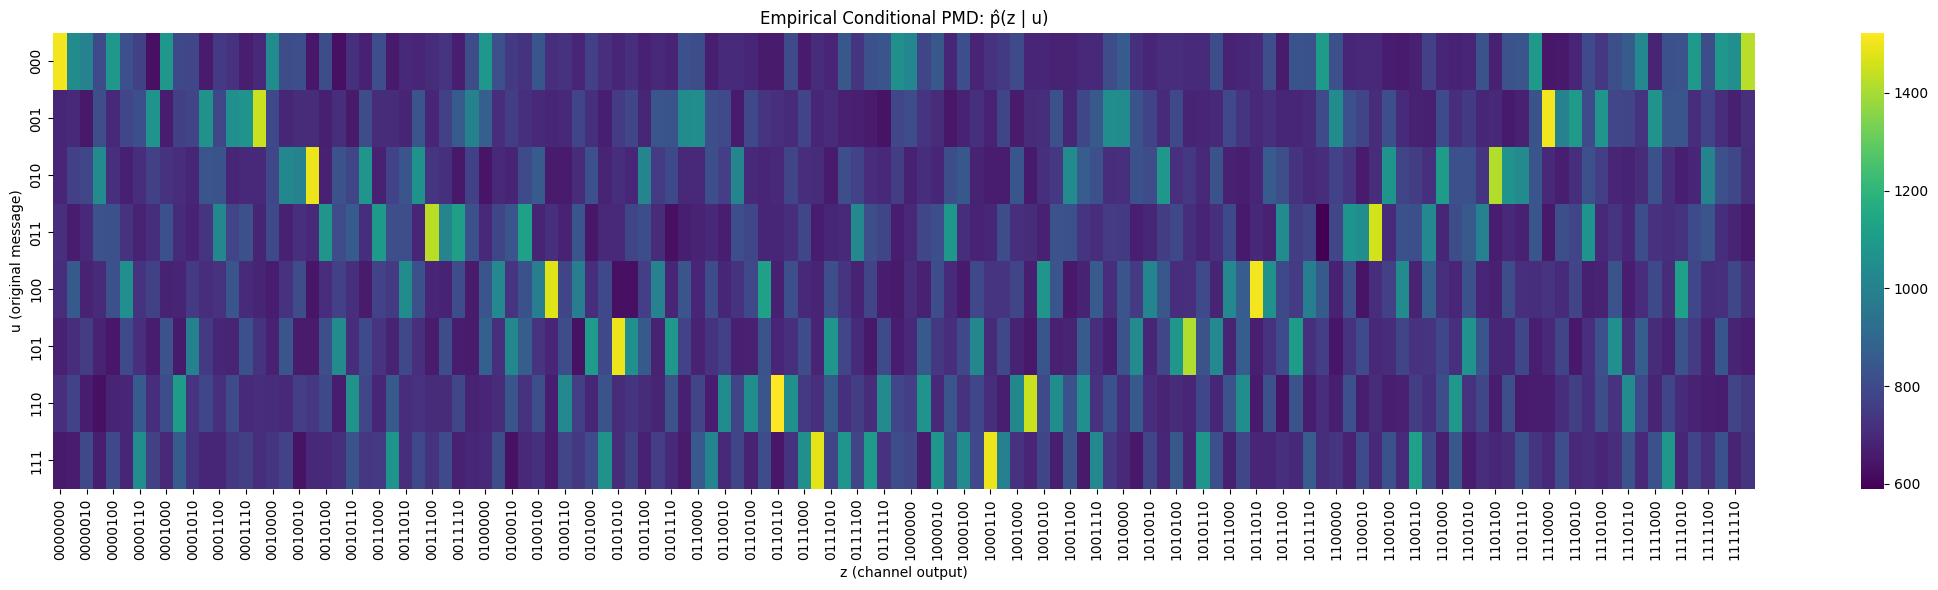

Mutual Information (with delta=0.4) I(U;Z): 0.021713
Entropy (with delta=0.4) H(U): 3.000000

For epsilon=0.2 and delta=0.35
Bob's Error Probability with epsilon=0.2: 0.32


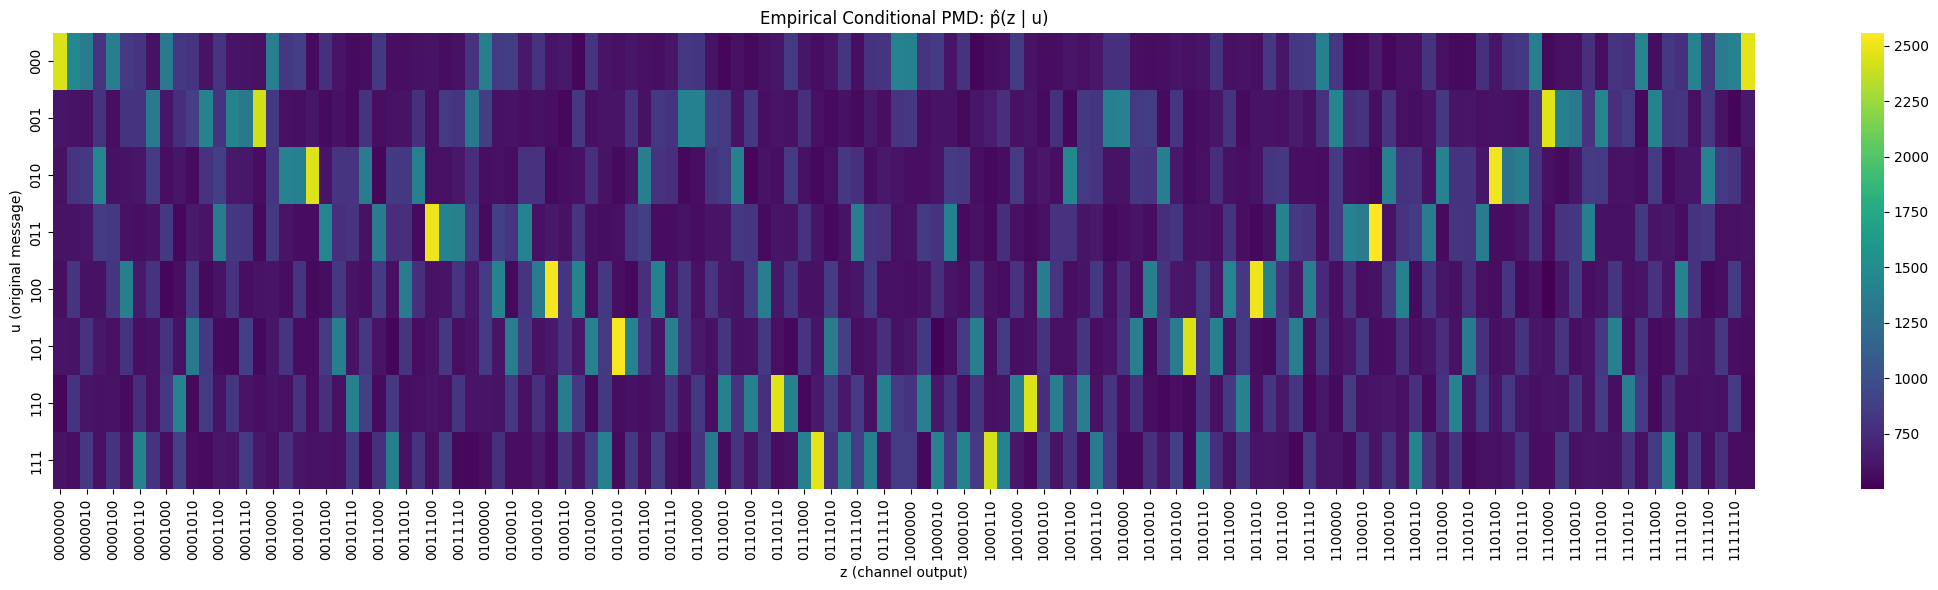

Mutual Information (with delta=0.35) I(U;Z): 0.099064
Entropy (with delta=0.35) H(U): 3.000000

For epsilon=0.25 and delta=0.3
Bob's Error Probability with epsilon=0.25: 0.3133333333333333


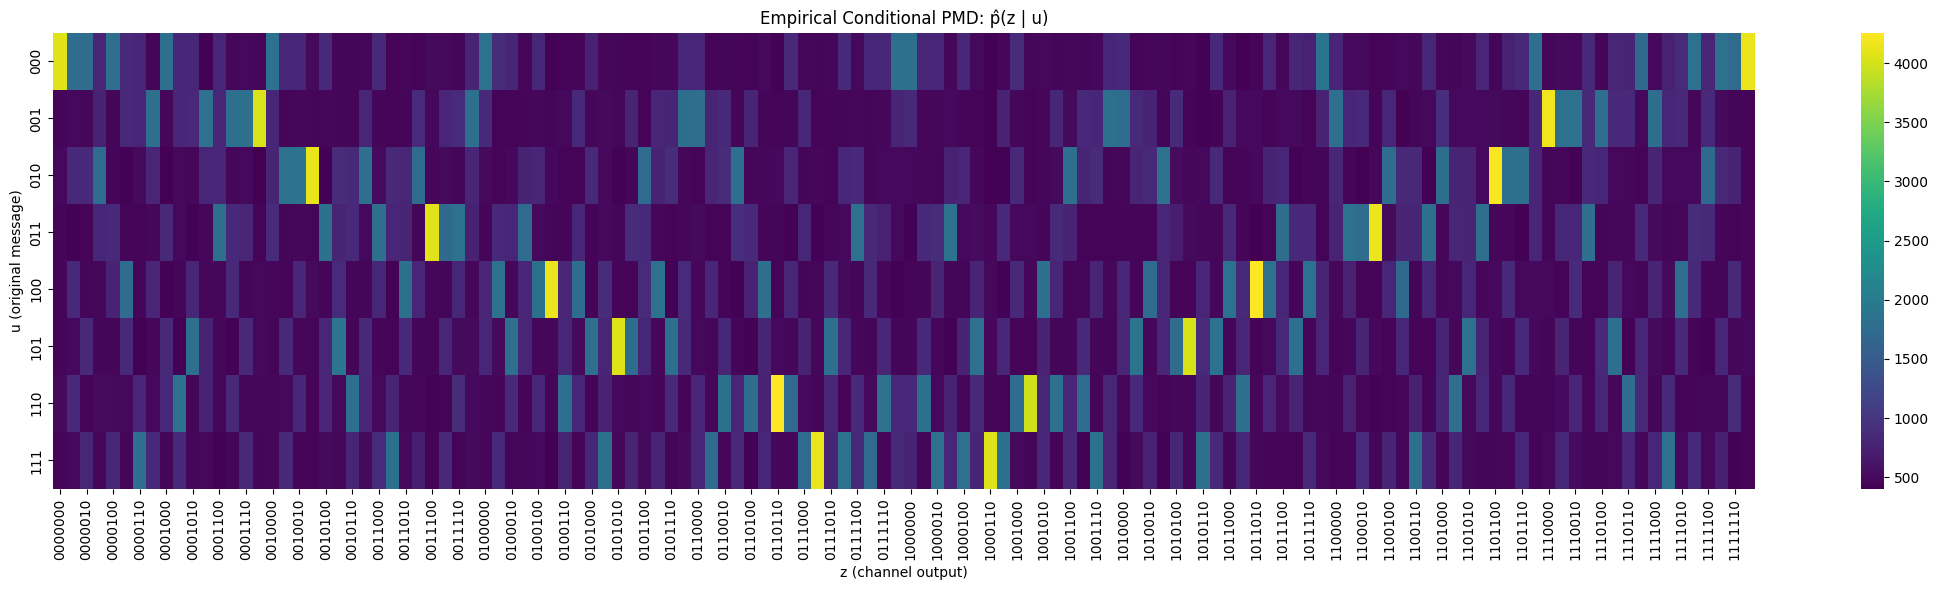

Mutual Information (with delta=0.3) I(U;Z): 0.272879
Entropy (with delta=0.3) H(U): 3.000000

For epsilon=0.3 and delta=0.3
Bob's Error Probability with epsilon=0.3: 0.3


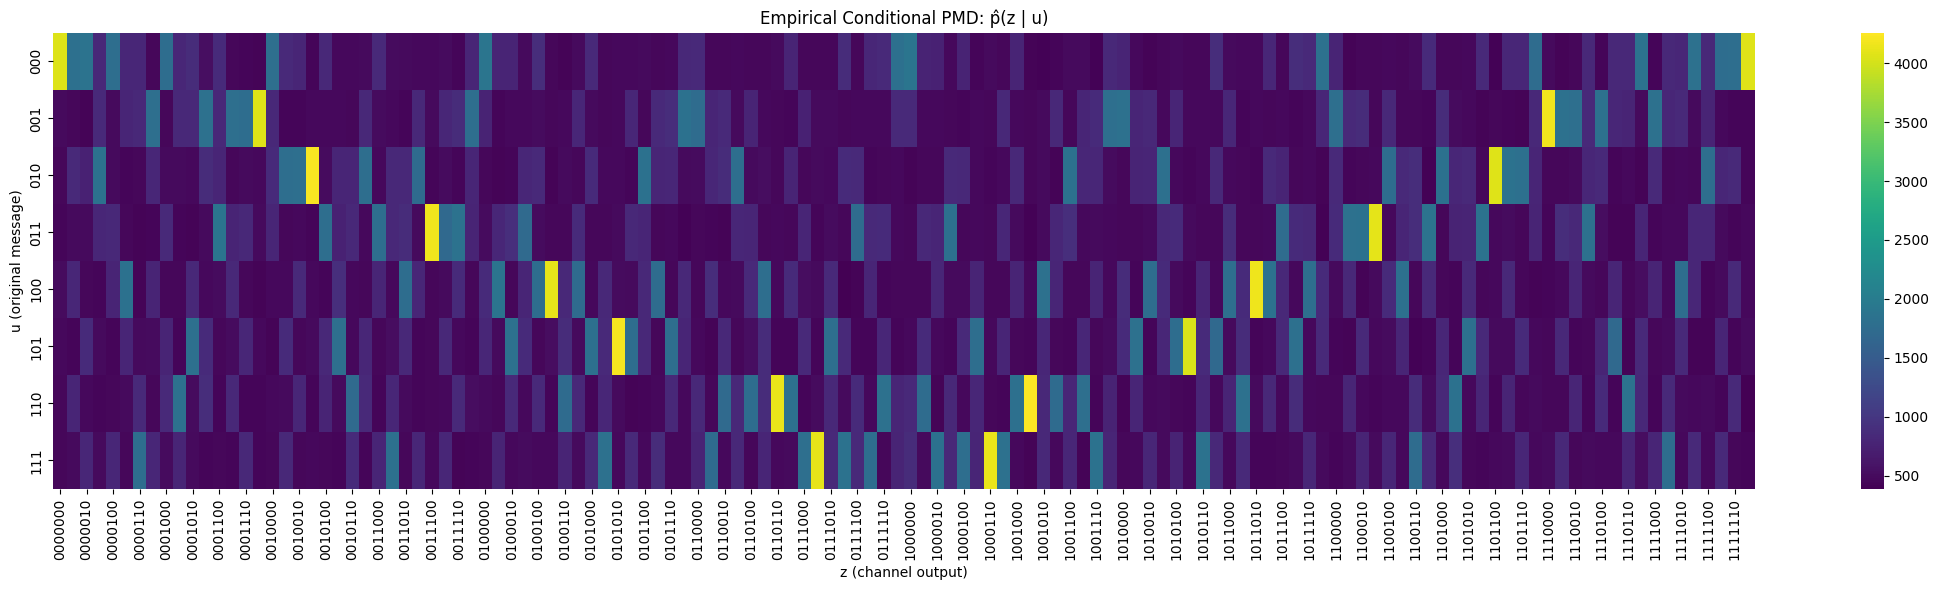

Mutual Information (with delta=0.3) I(U;Z): 0.273440
Entropy (with delta=0.3) H(U): 3.000000


In [68]:
epsilon_delta_pairs = [(0.01, 0.55), (0.05, 0.50), (0.1, 0.45), (0.15, 0.40), (0.20, 0.35), (0.25, 0.3), (0.3, 0.3)]

results = []

ber = []
m_i = []

for epsilon, delta in epsilon_delta_pairs:
    print(f"\nFor epsilon={epsilon} and delta={delta}")

    error_prob = []
    for _ in range(50):
        u = np.random.randint(0, 2, INPUT_LENGTH)
        x = encoder(u)

        # 6.1 Repeat the simulations in Tasks 3 with the wiretap BSC
        # Simulate Bob's observations
        y = bsc(x, epsilon)
        u_hat = decoder(y)
        n = number_of_errors(u, u_hat)
        # 6.2 Evaluate the resulting reliability in terms of Bob's error rate
        error_prob.append(compute_error_probability(u, u_hat))
    ber.append(np.mean(error_prob))
    print(f"Bob's Error Probability with epsilon={epsilon}: {np.mean(error_prob)}")

    # 6.1 Repeat the simulations in Task 4 with the wiretap BSC
    # 6.3
    # Simulate Eve's observations
    input_output_numbers_map = calculate_empirical_distribution_with_bsc(all_possible_input, iterations, delta)
    df = convert_to_data_frame(input_output_numbers_map)
    plot_empirical_distribution(df)
    total_samples = len(all_possible_input) * iterations
    p_uz, p_u, p_z = compute_distributions(input_output_numbers_map, total_samples)
    I_u_z, H_u = compute_mutual_information_and_entropy(p_uz, p_u, p_z)
    m_i.append(I_u_z)
    print(f"Mutual Information (with delta={delta}) I(U;Z): {I_u_z:.6f}")
    print(f"Entropy (with delta={delta}) H(U): {H_u:.6f}")

In [90]:
def simulate_wiretap_bsc(epsilon, delta, n_messages=10000):
    input_bits = np.random.randint(0, 2, n_messages * 3)
    u = input_bits.reshape(-1, 3)

    encoded_bits = []
    for group in u:
        encoded_bits.extend(encoder(group))
    encoded_bits = np.array(encoded_bits)

    # Passaggio attraverso BSC
    rx_bob_bits = bsc(encoded_bits, epsilon)
    rx_eve_bits = bsc(encoded_bits, delta)

    v = []
    for i in range(0, len(rx_eve_bits), 7):
        v.append(rx_eve_bits[i:i+3])
    v = np.array(v)

    u_flat = u.flatten()
    v_flat = v.flatten()

    # 3. Total Variation Distance
    real_joint = Counter(zip(u_flat, u_hat.flatten(), v_flat))
    real_joint_probs = {k: v / len(u_flat) for k, v in real_joint.items()}

    v_random = np.random.randint(0, 2, size=v_flat.shape)
    ideal_joint = Counter(zip(u_flat, u_flat, v_random))
    ideal_joint_probs = {k: v / len(u_flat) for k, v in ideal_joint.items()}

    tvd = total_variation_distance(real_joint_probs, ideal_joint_probs)

    return tvd

In [91]:
tvd_values = []
for epsilon, delta in epsilon_delta_pairs:
    tvd = simulate_wiretap_bsc(epsilon, delta, n_messages=5000)
    tvd_values.append(tvd)

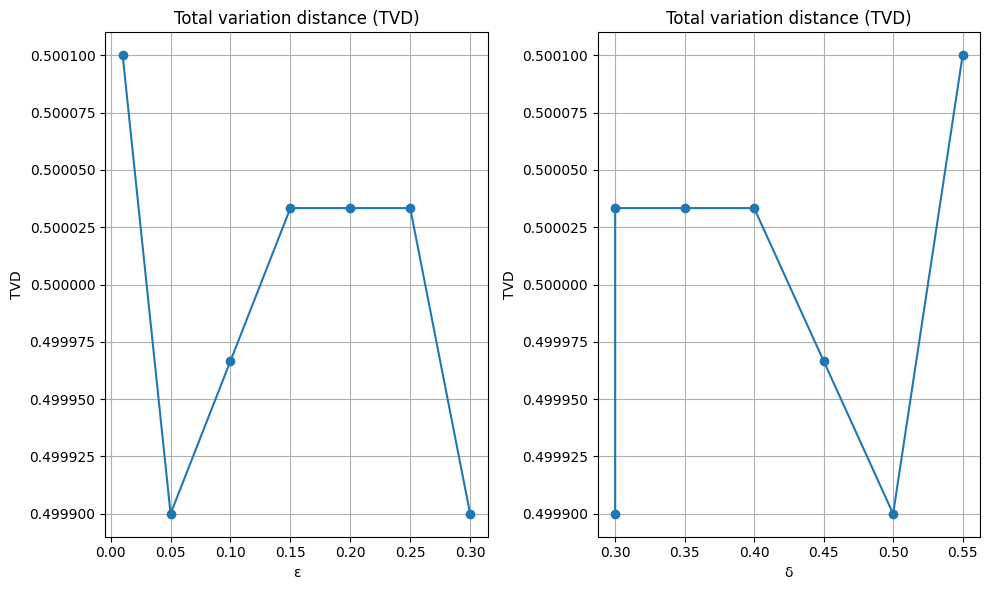

In [92]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
epsilon = [e for e, d in epsilon_delta_pairs]
plt.plot(epsilon, tvd_values, marker='o')
plt.title("Total variation distance (TVD)")
plt.xlabel("ε")
plt.ylabel("TVD")
plt.grid(True)

plt.subplot(1,2,2)
delta = [d for e, d in epsilon_delta_pairs]
plt.plot(delta, tvd_values, marker='o')
plt.title("Total variation distance (TVD)")
plt.xlabel("δ")
plt.ylabel("TVD")
plt.grid(True)

plt.tight_layout()
plt.show()

 Plot of the error decoding probability $\mathbb{P}[\hat{u}\neq u]$ as a function of $\epsilon$ for the BSC

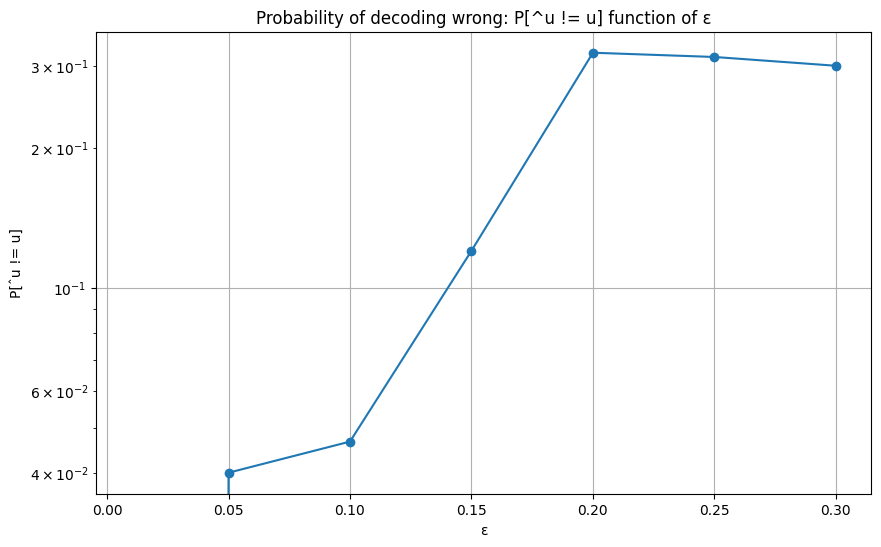

In [72]:
plt.figure(figsize=(10, 6))
epsilon = [e for e, d in epsilon_delta_pairs]
plt.semilogy(epsilon, ber, marker='o')
plt.title("Probability of decoding wrong: P[^u != u] function of ε")
plt.xlabel("ε")
plt.ylabel("P[ˆu != u]")
plt.grid(True)
plt.show()

Plot of the mutual information $I(u;z)$ as a function of $\delta$ for the BSC

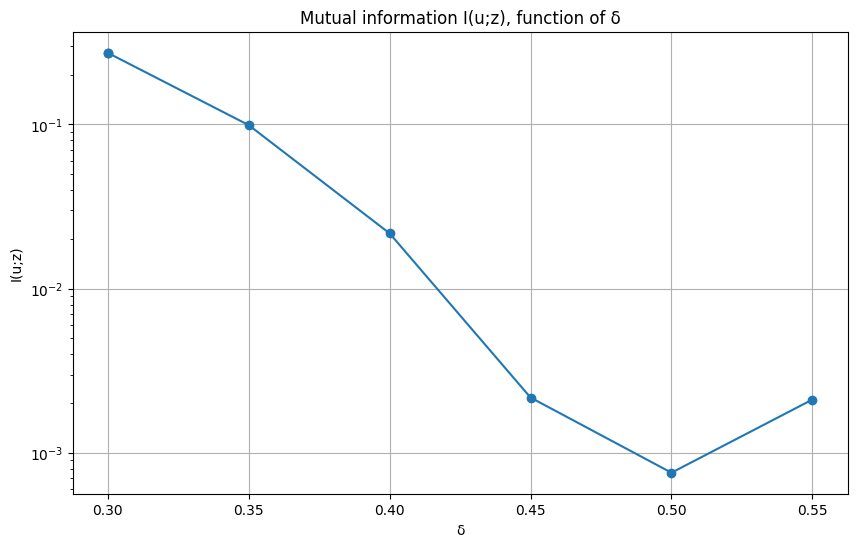

In [74]:
plt.figure(figsize=(10, 6))
delta = [d for e, d in epsilon_delta_pairs]
plt.semilogy(delta, m_i, marker='o')
plt.title("Mutual information I(u;z), function of δ")
plt.xlabel("δ")
plt.ylabel("I(u;z)")
plt.grid(True)
plt.show()

Contour plot of the security level $d(M,M^⋆)$ for your mechanism as a function of $\epsilon$ and $\delta$ in the wiretap BSC

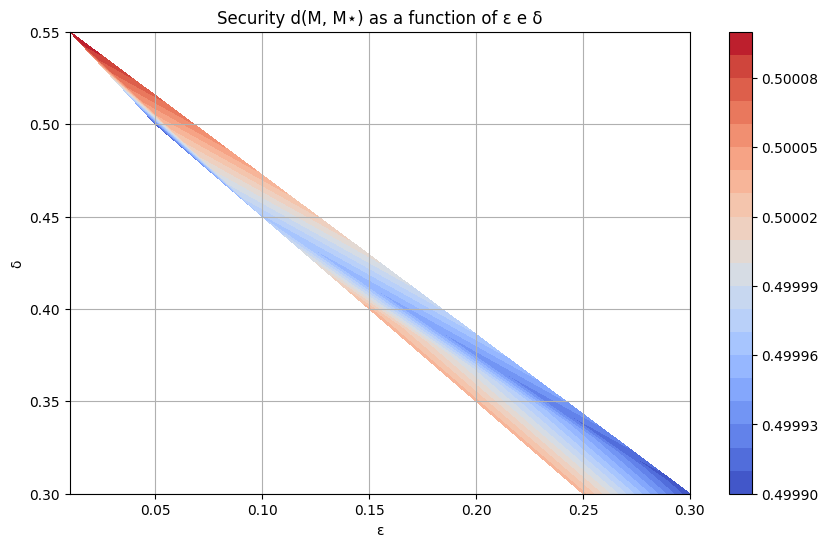

In [93]:
epsilon_values = np.array([pair[0] for pair in epsilon_delta_pairs])
delta_values = np.array([pair[1] for pair in epsilon_delta_pairs])
tvd_values = np.array(tvd_values)

plt.figure(figsize=(10, 6))
contour = plt.tricontourf(epsilon_values, delta_values, tvd_values, 20, cmap="coolwarm")
plt.colorbar(contour)
plt.title("Security d(M, M⋆) as a function of ε e δ")
plt.xlabel("ε")
plt.ylabel("δ")
plt.grid(True)
plt.show()

### TASK 7
Using a programming language of your choice implement the modulator + AWGN channel + demodulator so that
* the modulator outputs PAM symbols
* the AWGN channel can be simulated with arbitrary values of SNR
* it can be connected between the random binning encorder developed in Task 2, and the decoder developed in Task 3

In [46]:
SNR = 10
snr_list = np.arange(0, 31, 2)  # SNR da 0 a 30 dB a passi di 2
bers = []

In [47]:
#PAM Modulator
def pam_modulate(bits, M=128):
    k = int(np.log2(M))  # number of bits per symbol
    if len(bits) % k != 0:
        raise ValueError(f"Il numero di bit deve essere multiplo di {k} per PAM-{M}")

    bits = np.array(bits)
    symbols = []

    for i in range(0, len(bits), k):
        group = bits[i:i+k]
        # Converte il gruppo di bit in un numero decimale
        decimal_value = 0
        for j in range(k):
            decimal_value += group[j] << (k - j - 1)

        # Map su simboli PAM: da 0..127 a livelli centrati attorno a 0
        pam_symbol = 2 * decimal_value - (M - 1)
        symbols.append(pam_symbol)

    return np.array(symbols)

In [48]:
def awgn_channel(signal, snr_db=10):
    # Calcola la potenza del segnale
    signal_power = np.mean(signal**2)

    # Calcola il rapporto segnale/rumore lineare (non in dB)
    snr_linear = 10**(snr_db / 10)

    # Calcola la potenza del rumore
    noise_power = signal_power / snr_linear

    # Genera il rumore bianco gaussiano
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

    # Segnale ricevuto = segnale originale + rumore
    received_signal = signal + noise

    return received_signal

In [49]:
def pam_demodulate(received_signal, M=128):
    k = int(np.log2(M))  # numero di bit per simbolo
    bits_out = []

    # Costruisci la mappa dei simboli PAM ideali
    pam_levels = np.arange(-(M-1), M, step=2)  # ad esempio, -127, -125, ..., 125, 127

    for y in received_signal:
        # Trova il simbolo PAM ideale più vicino
        idx = np.argmin(np.abs(pam_levels - y))
        symbol = idx  # simbolo corrispondente a valore decimale

        # Converte il simbolo in bit
        bits = [(symbol >> (k-1-j)) & 1 for j in range(k)]
        bits_out.extend(bits)

    return np.array(bits_out)

In [50]:
def encoder_plus_pam_and_awgn(input, snr_db=10):
    encoded_bits = []
    for i in range(0, len(input), 3):
        group = input[i:i+3]
        encoded = encoder(group)
        encoded_bits.extend(encoded)
    encoded_bits = np.array(encoded_bits)

    pam_symbols = pam_modulate(encoded_bits, M=128)
    return awgn_channel(pam_symbols, snr_db=snr_db)


In [51]:
def decoder_and_demodulator_pam(received_symbols, snr_db=10):
    decoded_bits = pam_demodulate(received_symbols, M=128)

    recovered_bits = []
    for i in range(0, len(decoded_bits), 7):
        group = decoded_bits[i:i+7]
        recovered = decoder(group)
        recovered_bits.extend(recovered)

    return np.array(recovered_bits)

In [52]:
# Genera dei dati di input casuali
input_bits = np.random.randint(0, 2, 300)  # 100 gruppi da 3 bit

reconstructed_bits = decoder_and_demodulator_pam(encoder_plus_pam_and_awgn(input_bits, snr_db=SNR))

# Calcola e stampa il Bit Error Rate (BER)
n_errors = np.sum(input_bits != reconstructed_bits)
ber = n_errors / len(input_bits)
print(f"Bit Error Rate (BER): {ber}")

Bit Error Rate (BER): 0.36666666666666664


In [53]:
for snr in snr_list:
    reconstructed_bits = decoder_and_demodulator_pam(encoder_plus_pam_and_awgn(input_bits, snr_db=snr))
    n_errors = np.sum(input_bits != reconstructed_bits)
    ber = n_errors / len(input_bits)
    bers.append(ber)

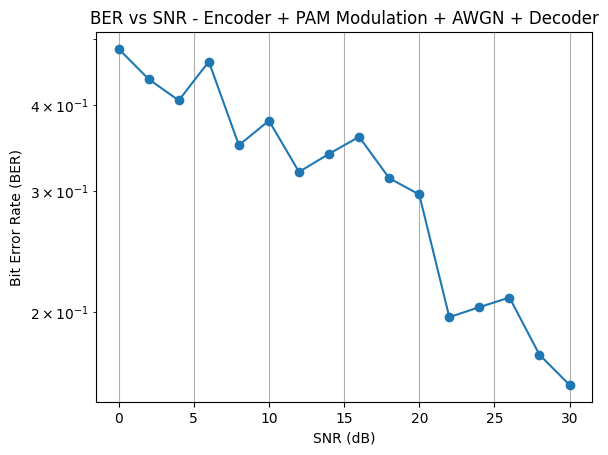

In [54]:
plt.semilogy(snr_list, bers, marker='o')
plt.grid(True)
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR - Encoder + PAM Modulation + AWGN + Decoder')
plt.show()

### TASK 8
Evaluate quantitatively the performace of the system and measure:
* the reliability in terms of Bob's error rate on the secret message
* the secrecy in terms of leaked information to Eve on the secret message $I(u;z)$
* the total variantion distance between $p_{u\hat{u}v}$ and $p_{u\hat{u}^*v^*}$ and the mechanism security in terms of distinguishability from the ideal counterpart
* the secrecy capacity of your system

over different SNR values for both channels.

In [79]:
def simulate_system(snr_bob, snr_eve, n_messages=10000):
    # Genera input casuali
    input_bits = np.random.randint(0, 2, n_messages * 3)
    u = input_bits.reshape(-1, 3)

    encoded_bits = []
    for group in u:
        encoded_bits.extend(encoder(group))

    encoded_bits = np.array(encoded_bits)

    # PAM modulazione
    tx_symbols = pam_modulate(encoded_bits, M=128)

    # Passaggio tramite canali AWGN
    rx_bob = awgn_channel(tx_symbols, snr_db=snr_bob)
    rx_eve = awgn_channel(tx_symbols, snr_db=snr_eve)

    # Demodulazione
    demod_bits_bob = pam_demodulate(rx_bob, M=128)
    demod_bits_eve = pam_demodulate(rx_eve, M=128)

    # Decodifica Bob
    recovered_bits_bob = []
    for i in range(0, len(demod_bits_bob), 7):
        recovered_bits_bob.extend(decoder(demod_bits_bob[i:i+7]))
    recovered_bits_bob = np.array(recovered_bits_bob)
    u_hat = recovered_bits_bob.reshape(-1, 3)

    # Per Eve: prende direttamente i primi 3 bit dopo demodulazione
    v = []
    for i in range(0, len(demod_bits_eve), 7):
        v.append(demod_bits_eve[i:i+3])  # prende i primi 3 bit
    v = np.array(v)

    # 1. Reliability: BER di Bob
    ber_bob = np.mean(u != u_hat)

    # 2. Secrecy: Mutual Information I(u;v)
    u_flat = u.flatten()
    v_flat = v.flatten()

    joint_counter = Counter(zip(u_flat, v_flat))
    p_uz = {k: v / len(u_flat) for k, v in joint_counter.items()}

    u_counter = Counter(u_flat)
    p_u = {k: v / len(u_flat) for k, v in u_counter.items()}

    v_counter = Counter(v_flat)
    p_z = {k: v / len(v_flat) for k, v in v_counter.items()}

    # Calcola mutual information e entropia
    mi_uv, H_u = compute_mutual_information_and_entropy(p_uz, p_u, p_z)

    # 3. Total Variation Distance
    # Real system
    real_joint = Counter(zip(u_flat, u_hat.flatten(), v_flat))
    real_joint_probs = {k: v / len(u_flat) for k, v in real_joint.items()}

    # Ideal system (u_hat perfectly = u, v random)
    v_random = np.random.randint(0, 2, size=v_flat.shape)
    ideal_joint = Counter(zip(u_flat, u_flat, v_random))
    ideal_joint_probs = {k: v / len(u_flat) for k, v in ideal_joint.items()}

    tvd = total_variation_distance(real_joint_probs, ideal_joint_probs)

    # 4. Secrecy Capacity
    secrecy_capacity = max(0, H_u - mi_uv)

    return ber_bob, mi_uv, tvd, secrecy_capacity

In [77]:
def plot_task_8(snr_variable, ber_list, mi_list, tvd_list, sc_list):
    plt.figure(figsize=(12, 8))
    plt.subplot(2,2,1)
    plt.semilogy(snr_variable, ber_list, marker='o')
    plt.grid(True)
    plt.title('BER di Bob')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')

    plt.subplot(2,2,2)
    plt.plot(snr_variable, mi_list, marker='o')
    plt.grid(True)
    plt.title('Mutual Information I(u;v)')
    plt.xlabel('SNR (dB)')
    plt.ylabel('I(u;v) [bit]')

    plt.subplot(2,2,3)
    plt.plot(snr_variable, tvd_list, marker='o')
    plt.grid(True)
    plt.title('Total Variation Distance')
    plt.xlabel('SNR (dB)')
    plt.ylabel('TVD')

    plt.subplot(2,2,4)
    plt.plot(snr_variable, sc_list, marker='o')
    plt.grid(True)
    plt.title('Secrecy Capacity')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Secrecy Capacity [bit]')

    plt.tight_layout()
    plt.show()

SNR_BOB = 0 dB, SNR_EVE = 0 dB --> BER: 0.46313, MI: 0.00000, TVD: 0.46313, Secrecy Cap: 1.00000
SNR_BOB = 2 dB, SNR_EVE = 0 dB --> BER: 0.44753, MI: 0.00007, TVD: 0.44753, Secrecy Cap: 0.99993
SNR_BOB = 4 dB, SNR_EVE = 0 dB --> BER: 0.42880, MI: 0.00005, TVD: 0.42880, Secrecy Cap: 0.99983
SNR_BOB = 6 dB, SNR_EVE = 0 dB --> BER: 0.41833, MI: 0.00001, TVD: 0.41833, Secrecy Cap: 0.99998
SNR_BOB = 8 dB, SNR_EVE = 0 dB --> BER: 0.40400, MI: 0.00002, TVD: 0.40400, Secrecy Cap: 0.99994
SNR_BOB = 10 dB, SNR_EVE = 0 dB --> BER: 0.40040, MI: 0.00004, TVD: 0.40040, Secrecy Cap: 0.99992
SNR_BOB = 12 dB, SNR_EVE = 0 dB --> BER: 0.38313, MI: 0.00004, TVD: 0.38313, Secrecy Cap: 0.99996
SNR_BOB = 14 dB, SNR_EVE = 0 dB --> BER: 0.36680, MI: 0.00006, TVD: 0.36680, Secrecy Cap: 0.99990
SNR_BOB = 16 dB, SNR_EVE = 0 dB --> BER: 0.34273, MI: 0.00023, TVD: 0.34273, Secrecy Cap: 0.99971
SNR_BOB = 18 dB, SNR_EVE = 0 dB --> BER: 0.31467, MI: 0.00022, TVD: 0.31467, Secrecy Cap: 0.99978
SNR_BOB = 20 dB, SNR_EVE 

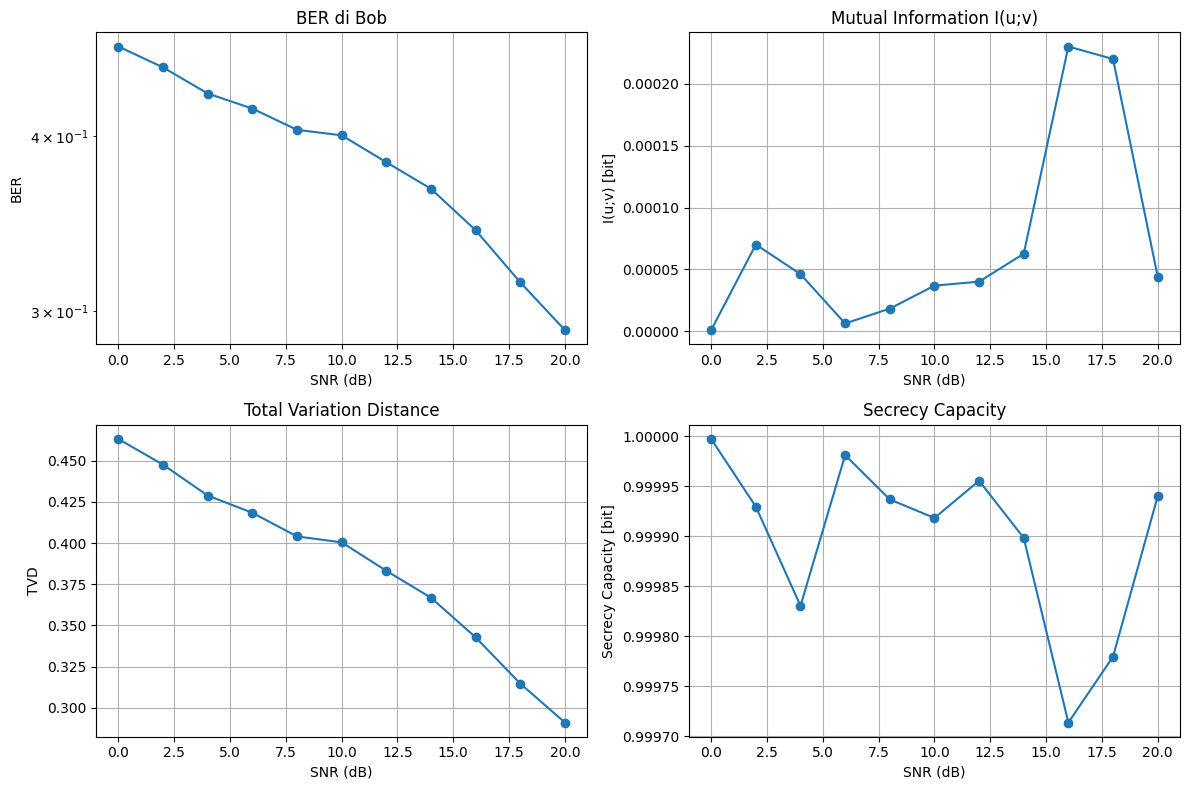

In [80]:
snr_bob_range = np.arange(0, 21, 2)
snr_eve_fixed = 0  # Eve ha un SNR molto basso, peggiore

ber_list = []
mi_list = []
tvd_list = []
sc_list = []

for snr_bob in snr_bob_range:
    ber_bob, mi_uv, tvd, secrecy_capacity = simulate_system(snr_bob=snr_bob, snr_eve=snr_eve_fixed, n_messages=5000)
    ber_list.append(ber_bob)
    mi_list.append(mi_uv)
    tvd_list.append(tvd)
    sc_list.append(secrecy_capacity)
    print(f"SNR_BOB = {snr_bob} dB, SNR_EVE = {snr_eve_fixed} dB --> BER: {ber_bob:.5f}, MI: {mi_uv:.5f}, TVD: {tvd:.5f}, Secrecy Cap: {secrecy_capacity:.5f}")

plot_task_8(snr_bob_range, ber_list, mi_list, tvd_list, sc_list)

SNR_BOB = 20 dB, SNR_EVE = 0 dB --> BER: 0.29187, MI: 0.00002, TVD: 0.29187, Secrecy Cap: 0.99997
SNR_BOB = 20 dB, SNR_EVE = 2 dB --> BER: 0.28267, MI: 0.00000, TVD: 0.28267, Secrecy Cap: 0.99997
SNR_BOB = 20 dB, SNR_EVE = 4 dB --> BER: 0.28267, MI: 0.00003, TVD: 0.28267, Secrecy Cap: 0.99993
SNR_BOB = 20 dB, SNR_EVE = 6 dB --> BER: 0.28860, MI: 0.00020, TVD: 0.28860, Secrecy Cap: 0.99976
SNR_BOB = 20 dB, SNR_EVE = 8 dB --> BER: 0.28867, MI: 0.00002, TVD: 0.28867, Secrecy Cap: 0.99996
SNR_BOB = 20 dB, SNR_EVE = 10 dB --> BER: 0.28427, MI: 0.00000, TVD: 0.28427, Secrecy Cap: 0.99999
SNR_BOB = 20 dB, SNR_EVE = 12 dB --> BER: 0.28073, MI: 0.00007, TVD: 0.28073, Secrecy Cap: 0.99993
SNR_BOB = 20 dB, SNR_EVE = 14 dB --> BER: 0.28253, MI: 0.00000, TVD: 0.28253, Secrecy Cap: 1.00000
SNR_BOB = 20 dB, SNR_EVE = 16 dB --> BER: 0.28487, MI: 0.00004, TVD: 0.28487, Secrecy Cap: 0.99995
SNR_BOB = 20 dB, SNR_EVE = 18 dB --> BER: 0.28820, MI: 0.00022, TVD: 0.28820, Secrecy Cap: 0.99976
SNR_BOB = 20 dB

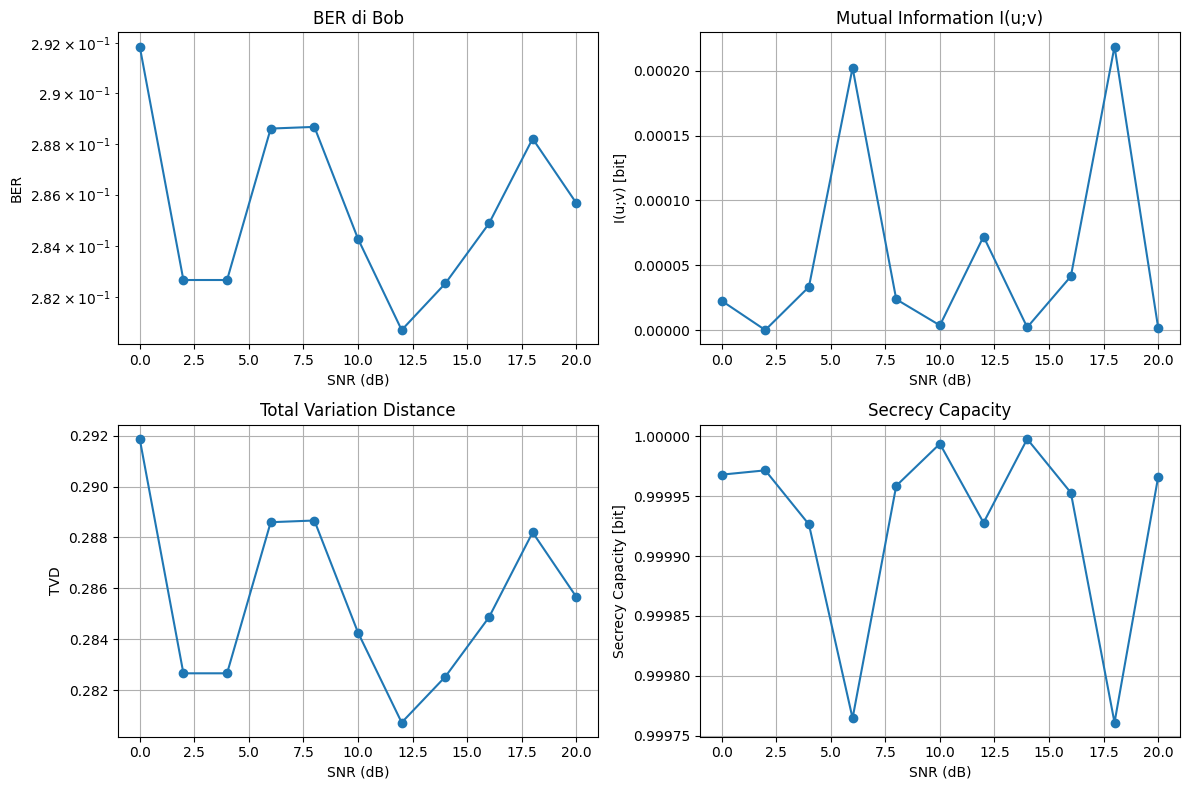

In [81]:
snr_eve_range = np.arange(0, 21, 2)
snr_bob_fixed = 20  # Bob ha SNR alto e fisso

ber_list = []
mi_list = []
tvd_list = []
sc_list = []

for snr_eve in snr_eve_range:
    ber_bob, mi_uv, tvd, secrecy_capacity = simulate_system(snr_bob=snr_bob_fixed, snr_eve=snr_eve, n_messages=5000)
    ber_list.append(ber_bob)
    mi_list.append(mi_uv)
    tvd_list.append(tvd)
    sc_list.append(secrecy_capacity)
    print(f"SNR_BOB = {snr_bob_fixed} dB, SNR_EVE = {snr_eve} dB --> BER: {ber_bob:.5f}, MI: {mi_uv:.5f}, TVD: {tvd:.5f}, Secrecy Cap: {secrecy_capacity:.5f}")

plot_task_8(snr_eve_range, ber_list, mi_list, tvd_list, sc_list)